In [4]:
import matplotlib.pyplot as plt
import numpy as np 
from keras.models import Model
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def load_data(N=None):
    inputs = np.load(r'C:/PythonWork/gol/gol_inputs_8_1.npy')
    outputs = np.load(r'C:/PythonWork/gol/gol_outputs_8_1.npy')
    
    if N:
        inputs = inputs[0:N]
        outputs = outputs[0:N]
    return inputs.astype('float32'), outputs.astype('float32')


train_ratio = 0.80
dataX, dataY = load_data()

# We don't need to shuffle as the dataset is already random
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1-train_ratio,shuffle=False)



In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(80000, 8, 8)
(80000, 8, 8)
(20000, 8, 8)
(20000, 8, 8)


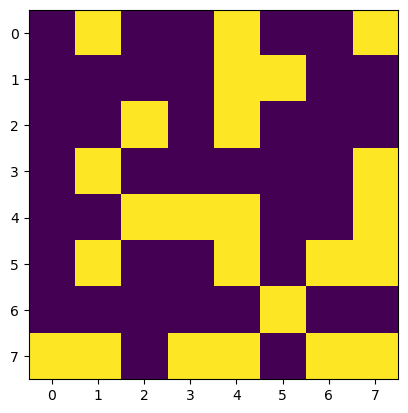

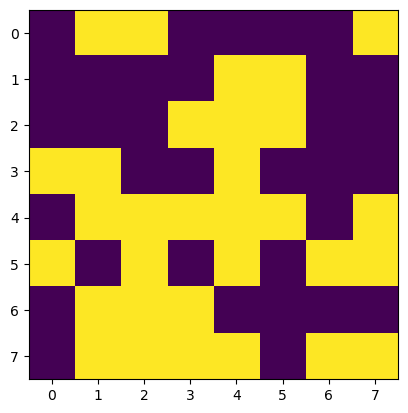

In [9]:
plt.figure()
plt.imshow(x_train[250,:,:]) #Gen 0
plt.figure()
plt.imshow(y_train[250,:,:]) #Gen 1


The model is defined in the following block. It's a bit different than in the link. Because Keras Conv2D can't handle wrapping borders ("wrap-around convolution"), I found the model would perform poorly at predicting cells on the board edges (since the 3x3 convs can't see across the edges!). So, I added an 8x8 layer so the model can see 'see' the rollover behaviour. This, along with the previously described conv network then get concatnated together, and final dense layer is used to recover the proper image size.

In [11]:
import keras
from keras.models import Model
from keras import layers

inputs = keras.Input(shape=(8,8,1))

y = layers.Conv2D(64,8,padding='valid',activation='linear')(inputs)
y = layers.PReLU()(y)
y = layers.Flatten()(y)

x = layers.Conv2D(2,3,padding='same',activation='linear')(inputs)
x = layers.PReLU()(x)
x = layers.Conv2D(2,1,padding='same',activation='linear')(x)
x = layers.PReLU()(x)
x = layers.Conv2D(1,1,padding='same',activation='linear')(x)
x = layers.PReLU()(x)

x = layers.Concatenate()([x, inputs])
x = layers.Flatten()(x) 
x = layers.Concatenate()([x, y])

x = layers.Dense(64,activation='sigmoid')(x)
x = layers.Reshape((8,8,-1))(x)


model = keras.Model(inputs, x)
model.summary()


Model: "functional"
┌─────────────────────┬───────────────────┬────────────┬───────────────────┐
│ Layer (type)        │ Output Shape      │    Param # │ Connected to      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 8, 8, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 2)   │         20 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 8, 8, 2)   │        128 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 2)   │          6 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 8, 8, 2)   │        128 │

In [13]:
# Training starts here !

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
checkpointer = ModelCheckpoint('sample.keras', verbose=True, save_best_only=True)

early_stopper = EarlyStopping(monitor='val_loss', mode='min', 
                              verbose=True, patience=7, 
                              restore_best_weights=True, 
                              min_delta=1e-6)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-8, patience=4, verbose=True)

#early_stopper = EarlyStopping(monitor='val_accuracy', mode='max', verbose=True, patience=8, restore_best_weights=True)
#reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, min_lr=1e-8, patience=5, verbose=True)

callbacks = [reduce_lr_callback, checkpointer, early_stopper]

history = model.fit(
    x=x_train,
    y=y_train,
    epochs=1000, #Don't limit by epochs
    batch_size=64, 
    shuffle=False,
    validation_split=0.2,
    verbose=2,
    callbacks=callbacks
)


Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.38165, saving model to sample.keras
1000/1000 - 17s - 17ms/step - accuracy: 0.7491 - loss: 0.4543 - val_accuracy: 0.8072 - val_loss: 0.3816 - learning_rate: 0.0010
Epoch 2/1000

Epoch 2: val_loss improved from 0.38165 to 0.19347, saving model to sample.keras
1000/1000 - 6s - 6ms/step - accuracy: 0.8662 - loss: 0.2950 - val_accuracy: 0.9145 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 3/1000

Epoch 3: val_loss improved from 0.19347 to 0.17048, saving model to sample.keras
1000/1000 - 6s - 6ms/step - accuracy: 0.9183 - loss: 0.1778 - val_accuracy: 0.9208 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 4/1000

Epoch 4: val_loss improved from 0.17048 to 0.16068, saving model to sample.keras
1000/1000 - 6s - 6ms/step - accuracy: 0.9242 - loss: 0.1658 - val_accuracy: 0.9270 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 5/1000

Epoch 5: val_loss improved from 0.16068 to 0.14587, saving model to sample.keras
1000/1000 - 10s - 10ms/

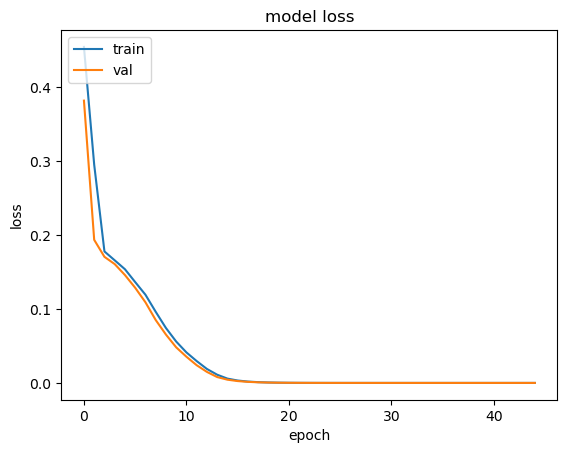

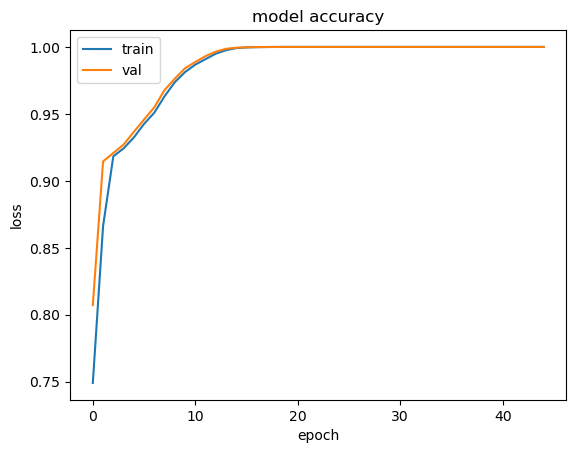

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    930691
         1.0       1.00      1.00      1.00    349309

    accuracy                           1.00   1280000
   macro avg       1.00      1.00      1.00   1280000
weighted avg       1.00      1.00      1.00   1280000



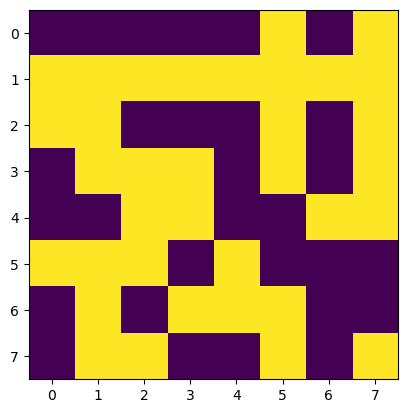

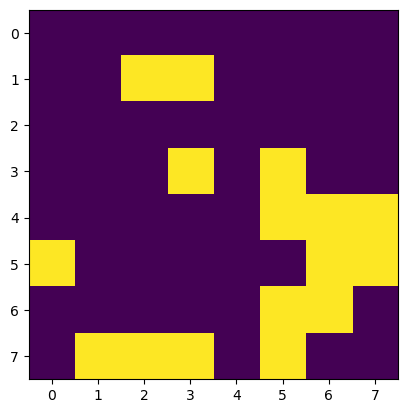

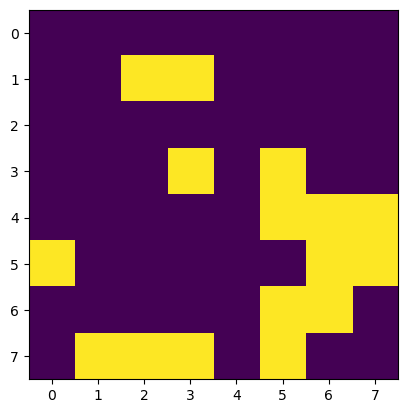

In [15]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Lets see how we did on the unseen data
ypreds = np.round(model.predict(x_test))
print(classification_report(y_test.ravel(),ypreds.ravel()))

# Lets look at a random board 
plt.figure()
plt.imshow(x_test[1001])
plt.figure()
plt.imshow(y_test[1001])
plt.figure()
plt.imshow(ypreds[1001])

We've achieved a perfect score! So it learned the rules of GOL. The model (19,625 params) is still quite a bit larger than the minimal one, but it trained-up in ~38 epochs, much faster than that in the articles.